In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
tf.keras.backend.set_floatx('float64')
import copy
from tqdm import tqdm

In [2]:
class ModelGraph:
    # graph of a full connected graph
    def __init__(self, model):#layer_sizes:list, activations:list):
        layer_sizes=[]
        for layer in model.layers:
            if type(layer.output_shape)==list:
                layer_sizes.append(layer.output_shape[0][-1])
            else:
                layer_sizes.append(layer.output_shape[-1])
        self.V=[] # vertexes
        self.E=[] # edges
        self.V.append(list(range(layer_sizes[0]))) # neuroni di input
        for l in layer_sizes[1:]:
            self.V.append([v+max(self.V[-1])+1 for v in list(range(l))])
            for v in self.V[-2]:
                for w in self.V[-1]:
                    self.E.append([v,w])
            self.V.append([v+max(self.V[-1])+1 for v in list(range(l))])
            for i in range(len(self.V[-1])):
                self.E.append([self.V[-2][i],self.V[-1][i]])
        self.w=[]
        for layer in model.layers:
            self.w.append(copy.deepcopy(layer.get_weights()))
    
    def predict(self, X):
        return [self.compute_edges(x)[-2:] for x in X]
    
    def error(self, X):
        return np.linalg.norm(X-self.predict(X),axis=1)

    def compute_edges(self, point):
        edges=[]
        p=point
        for i in range(1,len(self.w)):
            edges.extend((self.w[i][0]*(p.reshape(-1,1))).reshape(-1).tolist())
            r=np.dot([p],self.w[i][0])[0].tolist()
            q=np.tanh(np.dot([p],self.w[i][0])[0]+self.w[i][1])
            edges.extend(q.reshape(-1).tolist())
            p=q
        return edges
    
    def set_adj_entry(self, A, index, value):
        i,j=self.E[index]
        A[i,j]=value
        A[j,i]=value
        
    def compute_adiacent_matrix(self,point):
        edges=self.compute_edges(point)
        max_vertex_index=max([max(v) for v in self.V])
        A=np.zeros((max_vertex_index+1,max_vertex_index+1))
        for i in range(len(edges)):
            self.set_adj_entry(A,i,edges[i])
            
        return A
    
    def compute_energy(self,point):
        return np.sum(np.absolute(np.real(np.linalg.eig(self.compute_adiacent_matrix(point))[0])))

In [3]:
theta=np.linspace(0, 2*np.pi, num=200)
eta=[2*i*np.pi/3 for i in range(3)]
r0=0.8
r1=0.1

X=[]
for e in eta:
    x0=r0*np.cos(e)
    y0=r0*np.sin(e)
    print(x0,y0)
    for t in theta:
        X.append([x0+r1*np.cos(t),y0+r1*np.sin(t)])
X=np.array(X)

0.8 0.0
-0.39999999999999986 0.6928203230275511
-0.40000000000000036 -0.6928203230275507


(-1.0, 1.0, -1.0, 1.0)

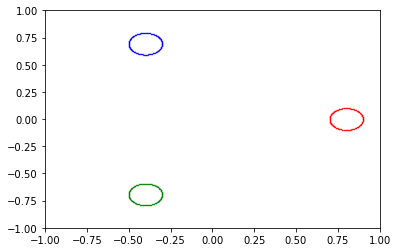

In [4]:
plt.scatter(X[:200,0],X[:200,1],s=.1,c='red')
plt.scatter(X[200:400,0],X[200:400,1],s=.1,c='blue')
plt.scatter(X[400:600,0],X[400:600,1],s=.1, c='green')
plt.axis([-1,1,-1,1])

In [5]:
input=tf.keras.layers.Input(shape=(2,),dtype=tf.float64)
encoded=tf.keras.layers.Dense(16,activation='tanh',dtype=tf.float64)(input)
encoded=tf.keras.layers.Dense(4,activation='tanh',dtype=tf.float64)(encoded)
decoded=tf.keras.layers.Dense(16,activation='tanh',dtype=tf.float64)(encoded)
output=tf.keras.layers.Dense(2,activation='tanh',dtype=tf.float64)(decoded)
model=tf.keras.models.Model(input,output)
model.compile(optimizer="Adam", loss="mse")
enc=tf.keras.models.Model(input,encoded)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 230
Trainable params: 230
Non-trainable params: 0
_________________________________________________________________


2022-07-03 18:03:34.987317: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-03 18:03:34.987609: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


In [6]:
#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(50, 6))
total_epochs=20000
epochs=1000
model_graphs=[]
history=[]
pbar=tqdm(total=int(total_epochs/epochs))
for i in range(1,int(total_epochs/epochs)-1):
    history.append(model.fit(X,X,epochs=epochs,verbose=0))
    model_graphs.append(ModelGraph(model))
    pbar.update(1)
    #ax0.plot(range(len(history[-1].history['loss'])),history[-1].history['loss'])
    #ax0.set_title('loss')
    #ax1.plot(range(len(X)),[model_graphs[-1].compute_energy(x) for x in X])
pbar.close()

 90%|██████████████████████████████████████▋    | 18/20 [07:42<00:51, 25.70s/it]


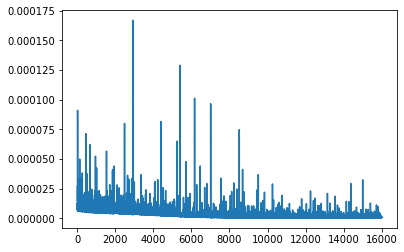

In [7]:
t_h=[]
for h in history:
    t_h.extend(h.history['loss'])
plt.plot(range(len(t_h)-2000),t_h[2000:])

In [8]:
E=[]
for mg in model_graphs:
    E.append([mg.compute_energy(x) for x in X])

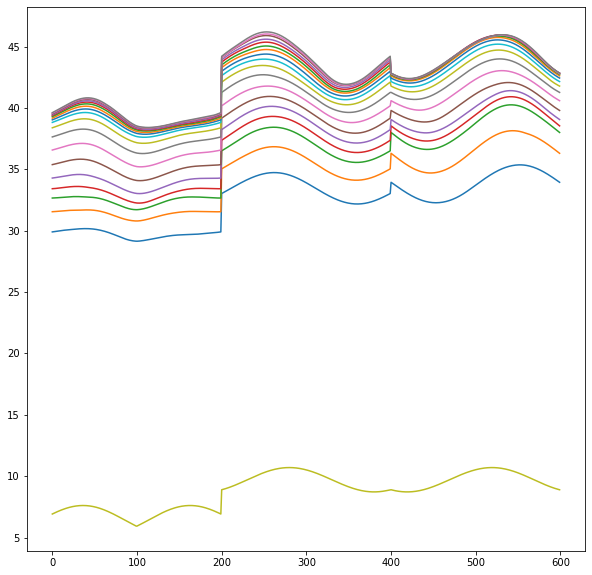

In [44]:
plt.figure(figsize=(10,10))
for i in range(len(E)):
    plt.plot(range(len(E[i])),E[i])
plt.plot(range(len(E_u)),E_u)

In [43]:
np.tanh(1)

0.7615941559557649

In [18]:
input_u=tf.keras.layers.Input(shape=(2,),dtype=tf.float64)
encoded_u=tf.keras.layers.Dense(16,activation='linear',dtype=tf.float64)(input_u)
encoded_u=tf.keras.layers.Dense(4,activation='linear',dtype=tf.float64)(encoded_u)
decoded_u=tf.keras.layers.Dense(16,activation='linear',dtype=tf.float64)(encoded_u)
output_u=tf.keras.layers.Dense(2,activation='linear',dtype=tf.float64)(decoded_u)
model_u=tf.keras.models.Model(input_u,output_u)
model_u.compile(optimizer="Adam", loss="mse")
enc=tf.keras.models.Model(input_u,encoded_u)
model_u.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_10 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 34        
Total params: 230
Trainable params: 230
Non-trainable params: 0
_________________________________________________________________


In [37]:
w=[]
w.append([np.zeros((2,16)),np.zeros(16)])
w[-1][0][0,0]=w[-1][0][1,1]=1.
w.append([np.zeros((16,4)),np.zeros(4)])
for i in range(4):
    w[-1][0][i,i]=1.
w.append([np.zeros((4,16)),np.zeros(16)])
for i in range(4):
    w[-1][0][i,i]=1.
w.append([np.zeros((16,2)),np.zeros(2)])
for i in range(2):
    w[-1][0][i,i]=1.


In [38]:
for i in range(1,len(model_u.layers)):
    model_u.layers[i].set_weights(w[i-1])

In [41]:
mg_u=ModelGraph(model_u)
E_u=[mg_u.compute_energy(x) for x in X]

In [9]:
n=[]
for i in range(len(E)-1):
    n.append(np.linalg.norm(np.array(E[i+1])-np.array(E[i])))

In [10]:
T=np.linspace(-2,2,1000)
E_m=np.zeros((len(T),len(T)))
mg=model_graphs[-1]

In [11]:
pbar=tqdm(total=len(T)**2)
for i in range(len(T)):
    for j in range(len(T)):
        E_m[i,j]=mg.compute_energy(np.array([T[i],T[j]]))
        pbar.update(1)
pbar.close()

100%|████████████████████████████████| 1000000/1000000 [23:27<00:00, 710.64it/s]


In [ ]:
pbar.close()

In [ ]:
i=0

In [ ]:
errors[i]=np.linalg.norm(model.predict(np.array([[T[i],t] for t in T]))-np.array([[T[i],t] for t in T]),axis=1)

In [12]:
errors=np.zeros((len(T),len(T)))
pbar=tqdm(total=len(T))
for i in range(len(T)):
    errors[i]=np.linalg.norm(model.predict(np.array([[T[i],t] for t in T]))-np.array([[T[i],t] for t in T]),axis=1)
    pbar.update(1)
pbar.close()

100%|███████████████████████████████████████| 1000/1000 [01:04<00:00, 15.40it/s]


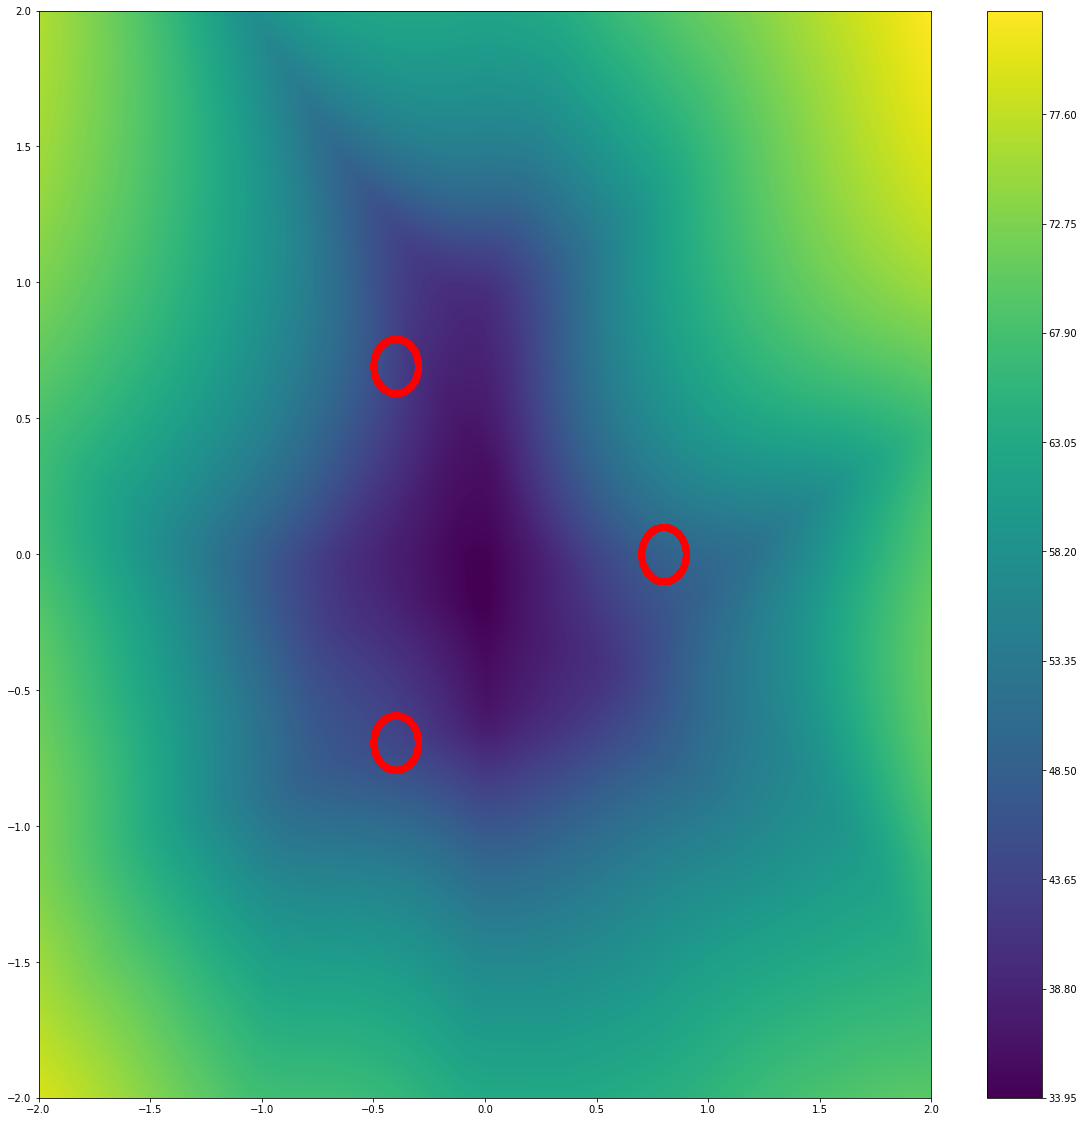

In [13]:
plt.figure(figsize=(20,20))
plt.contourf(T,T,E_m,1000)
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c='red')

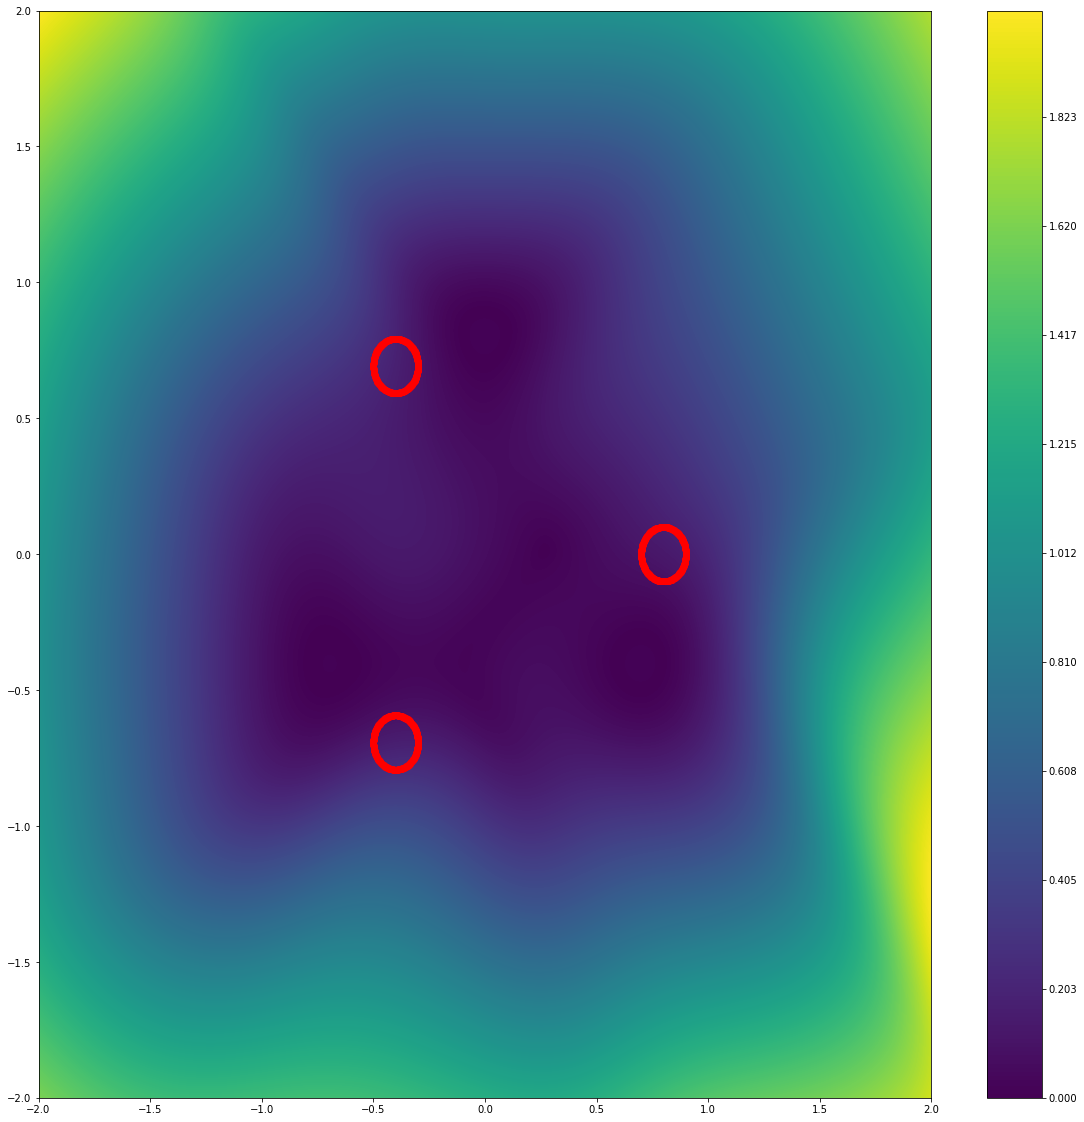

In [14]:
plt.figure(figsize=(20,20))
plt.contourf(T,T,errors,1000)
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c='red')

In [ ]:
Y=model.predict(X[200:400])

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,figsize=(50, 6))

ax0.plot(range(len(history.history['loss'])-1000),history.history['loss'][1000:])
ax1.set_title('training error')
for i in range(1,2):
    ax1.plot(range(200),np.linalg.norm(X[i*200:(i+1)*200,:]-Y[(i-1)*200:(i)*200,:],axis=1))

ax2.set_title('error on data set')
ax2.scatter(X[:,0],X[:,1])
ax2.scatter(Y[:,0],Y[:,1])

In [ ]:
# Tracciamento dei percorsi di attivazione e ricostruzione della topologia dei pattern di attivazione

In [ ]:
w=[]
for layer in model.layers:
    w.append(layer.get_weights())

In [ ]:
w[1][0].shape

In [ ]:
model.input.shape.dims[-1].value

In [ ]:
### Numero i nodi:
nodes=[]
for layer in model.layers:
    if type(layer.output_shape)==list:
        l=layer.output_shape[0][-1]
        nodes.append(list(range(l)))
    else:
        l=layer.output_shape[-1]
        nodes.append(list(range(l)))
        nodes.append(list(range(l)))
nodes

In [ ]:
import copy

In [ ]:
mg=ModelGraph(model)

In [ ]:
mg1=ModelGraph(model)

In [ ]:
mg2=ModelGraph(model)

In [ ]:
mg.compute_energy(X[0])

In [ ]:
mg1.compute_energy(X[0])

In [ ]:
mg2.compute_energy(X[0])

In [ ]:
E=[mg.compute_energy(x) for x in X]

In [ ]:
E1=[mg1.compute_energy(x) for x in X]

In [ ]:
E2=[mg2.compute_energy(x) for x in X]

In [ ]:
#plt.plot(range(len(E)),E-min(E),c='red')
#plt.plot(range(len(E1)),E1-min(E1),c='blue')
#plt.plot(range(len(E2)),E2-min(E2),c='green')

plt.plot(range(len(E)),E,c='red')
plt.plot(range(len(E1)),E1,c='blue')
plt.plot(range(len(E2)),E2,c='green')

In [ ]:
a=np.linalg.norm(X-[mg.compute_edges(x)[-2:] for x in X], axis=1)
b=np.linalg.norm(X-[mg1.compute_edges(x)[-2:] for x in X], axis=1)
c=np.linalg.norm(X-[mg2.compute_edges(x)[-2:] for x in X], axis=1)

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(range(len(E)),np.linalg.norm(X-[mg.compute_edges(x)[-2:] for x in X], axis=1),c='red')
plt.plot(range(len(E1)),np.linalg.norm(X-[mg1.compute_edges(x)[-2:] for x in X], axis=1),c='blue')
plt.plot(range(len(E2)),np.linalg.norm(X-[mg2.compute_edges(x)[-2:] for x in X], axis=1),c='green')

In [ ]:
max(E-min(E))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(20, 10))
ax0.scatter(X[:,0],X[:,1],c=E,cmap='viridis')
abs_err=np.linalg.norm(X-[mg.compute_edges(x)[-2:] for x in X], axis=1)
#ax0.colorbar()
ax1.scatter(X[:,0],X[:,1],c=abs_err)

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(20, 10))
ax0.scatter(X[:,0],X[:,1],c=E,cmap='viridis')
abs_err=np.linalg.norm(X-[mg1.compute_edges(x)[-2:] for x in X], axis=1)
#ax0.colorbar()
ax1.scatter(X[:,0],X[:,1],c=abs_err)

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(20, 10))
ax0.scatter(X[:,0],X[:,1],c=E,cmap='viridis')
abs_err=np.linalg.norm(X-[mg2.compute_edges(x)[-2:] for x in X], axis=1)
#ax0.colorbar()
ax1.scatter(X[:,0],X[:,1],c=abs_err)

In [ ]:
ax = plt.axes(projection='3d')
z=(E2-min(E2))[:200]
ax.scatter3D(X[:200,0], X[:200,1], z, c=z, cmap='Greens');
z=(E2-min(E2))[200:400]
ax.scatter3D(X[200:400,0], X[200:400,1], z, c=z, cmap='Greens');
z=(E2-min(E2))[400:600]
ax.scatter3D(X[400:600,0], X[400:600,1], z, c=z, cmap='Greens');

In [ ]:
Y=model.predict(X)

In [ ]:
abs_err=np.linalg.norm(X-Y, axis=1)

In [ ]:
max((E-min(E))/max(E))

In [ ]:
plt.plot(range(200),(abs_err[:200]-min(abs_err[:200]))/(max(abs_err[:200])-min(abs_err[:200])),c='red')
plt.plot(range(200),(E[:200]-min(E[:200]))/(max(E[:200])-min(E[:200])),c='green')
plt.plot(range(200,400),(abs_err[200:400]-min(abs_err[200:400]))/(max(abs_err[200:400])-min(abs_err[200:400])),c='red')
plt.plot(range(200,400),(E[200:400]-min(E[200:400]))/(max(E[200:400])-min(E[200:400])),c='green')
plt.plot(range(400,600),(abs_err[400:600]-min(abs_err[400:600]))/(max(abs_err[400:600])-min(abs_err[400:600])),c='red')
plt.plot(range(400,600),(E[400:600]-min(E[400:600]))/(max(E[400:600])-min(E[400:600])),c='green')

In [ ]:
plt.plot(range(len(abs_err)),(abs_err-min(abs_err))/(max(abs_err)-min(abs_err)),c='red')
plt.plot(range(len(abs_err)),(E-min(E))/(max(E)-min(E)),c='green')